In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

processed_file_path = "../data/processed/processed_data.csv"
data = pd.read_csv(processed_file_path)

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
base_line_test_data = test_data.copy()
train_data['signal_quantile'] = pd.qcut(train_data['signal'], 10, labels=False)
quantile_summary = train_data.groupby('signal_quantile')['signal'].agg(['min', 'max']).reset_index()

bins = [-np.inf] + quantile_summary['max'].tolist() + [np.inf]
print("Bins:")
print(bins)

print("Quantile Summary:")
print(quantile_summary)

positive_signals_std = train_data[train_data['signal'] > 0]['signal'].std()
negative_signals_std = train_data[train_data['signal'] < 0]['signal'].std()

buy_quantiles = quantile_summary[quantile_summary['max'] >= positive_signals_std]['signal_quantile'].tolist()
sell_quantiles = quantile_summary[quantile_summary['min'] <= -negative_signals_std]['signal_quantile'].tolist()
print(f"Buy quantiles: {buy_quantiles}")
print(f"Sell quantiles: {sell_quantiles}")


Bins:
[-inf, -0.0126631170999312, -0.008347696736757, -0.0053141359849129, -0.0026471630860451, -0.0001825653480221, 0.0022790556731195, 0.0049271373250957, 0.0080094999625867, 0.0123688183831138, 0.0372032712589485, inf]
Quantile Summary:
   signal_quantile       min       max
0                0 -0.041569 -0.012663
1                1 -0.012659 -0.008348
2                2 -0.008346 -0.005314
3                3 -0.005312 -0.002647
4                4 -0.002647 -0.000183
5                5 -0.000182  0.002279
6                6  0.002279  0.004927
7                7  0.004927  0.008009
8                8  0.008010  0.012369
9                9  0.012370  0.037203
Buy quantiles: [7, 8, 9]
Sell quantiles: [0, 1, 2]


In [113]:
def assign_trading_signals(data, bins, buy_quantiles, sell_quantiles):
    data['signal_quantile'] = pd.cut(data['signal'], bins=bins, labels=False, include_lowest=True)
    
    # Initialize trading signals
    data['trade_signal'] = 0

    # Assign buy and sell signals
    data.loc[data['signal_quantile'].isin(buy_quantiles), 'trade_signal'] = 1
    data.loc[data['signal_quantile'].isin(sell_quantiles), 'trade_signal'] = -1

    return data

test_data_with_signals = assign_trading_signals(test_data, bins, buy_quantiles, sell_quantiles)

test_data_with_signals['cumulative_returns'] = test_data_with_signals.groupby('signal_quantile')['equity_returns'].cumsum()

# Create a summary table for the test data
test_group_summary = test_data_with_signals.groupby('signal_quantile').agg({
    'signal': ['min', 'max', 'mean'],
    'equity_returns': ['mean', 'min', 'max', 'std', 'count'],
    'cumulative_returns': ['last']
}).reset_index()

print("Test Group Summary by Signal Quantile:")
print(test_group_summary)

Test Group Summary by Signal Quantile:
  signal_quantile    signal                     equity_returns            \
                        min       max      mean           mean       min   
0               0 -0.035731 -0.012667 -0.017365      -0.000276 -0.030772   
1               1 -0.012645 -0.008350 -0.010320      -0.000689 -0.031999   
2               2 -0.008335 -0.005315 -0.006783      -0.000251 -0.031989   
3               3 -0.005311 -0.002648 -0.003941       0.000272 -0.037488   
4               4 -0.002642 -0.000185 -0.001438       0.000006 -0.033433   
5               5 -0.000182  0.002275  0.001038       0.000162 -0.029504   
6               6  0.002286  0.004921  0.003572      -0.000062 -0.031690   
7               7  0.004943  0.008006  0.006427       0.000562 -0.031283   
8               8  0.008012  0.012358  0.010030       0.000702 -0.034718   
9               9  0.012370  0.035097  0.016928       0.000187 -0.031268   

                            cumulative_returns  

## Calculate Strategy Returns

We will calculate the strategy returns by multiplying the equity returns with the assigned trade signals.

In [114]:
def calculate_strategy_returns(data):
    trading_fee = 0.0001
    data['strategy_returns'] = data['equity_returns'] * data['trade_signal']
    data['trading_fee'] = abs(data['trade_signal']) * data['equity_curve'] * (-trading_fee)
    data['strategy_returns'] += data['trading_fee']
    data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod() - 1
    return data

test_data_with_returns = calculate_strategy_returns(test_data_with_signals)
print(test_data_with_returns[['equity_returns', 'trade_signal', 'strategy_returns', 'cumulative_strategy_returns']].tail(20))


       equity_returns  trade_signal  strategy_returns  \
49976       -0.012700            -1          0.012653   
49977        0.000242            -1         -0.000288   
49978        0.004523            -1         -0.004569   
49979        0.009278             1          0.009231   
49980        0.001146            -1         -0.001193   
49981       -0.000104             0         -0.000000   
49982       -0.008700             0         -0.000000   
49983       -0.005961             1         -0.006008   
49984        0.000916             0          0.000000   
49985        0.003793             0          0.000000   
49986       -0.008265             0         -0.000000   
49987       -0.017004             0         -0.000000   
49988        0.004373             0          0.000000   
49989        0.000738             1          0.000692   
49990       -0.001032            -1          0.000987   
49991       -0.010942             1         -0.010987   
49992        0.002981          

In [115]:
def calculate_baseline_strategy_returns(data):
    trading_fee = 0.0001
    data['baseline_strategy_returns'] = 0
    data.loc[data['signal'] > 0, 'baseline_strategy_returns'] = data['equity_returns']
    data.loc[data['signal'] < 0, 'baseline_strategy_returns'] = -data['equity_returns']
    data['trading_fee'] = data['equity_curve'] * (-trading_fee)
    data['baseline_strategy_returns'] += data['trading_fee']
    data['cumulative_baseline_strategy_returns'] = (1 + data['baseline_strategy_returns']).cumprod() - 1
    
    return data

test_data_with_baseline_returns = calculate_baseline_strategy_returns(base_line_test_data)
print(test_data_with_baseline_returns[['signal', 'equity_returns','baseline_strategy_returns', 'cumulative_baseline_strategy_returns']].tail(20))

         signal  equity_returns  baseline_strategy_returns  \
49976 -0.007581       -0.012700                   0.012653   
49977 -0.006999        0.000242                  -0.000288   
49978 -0.008544        0.004523                  -0.004569   
49979  0.009422        0.009278                   0.009231   
49980 -0.008095        0.001146                  -0.001193   
49981  0.003710       -0.000104                  -0.000151   
49982  0.001428       -0.008700                  -0.008747   
49983  0.008251       -0.005961                  -0.006008   
49984  0.002362        0.000916                   0.000870   
49985 -0.002363        0.003793                  -0.003840   
49986 -0.000360       -0.008265                   0.008219   
49987  0.001748       -0.017004                  -0.017050   
49988  0.004239        0.004373                   0.004328   
49989  0.016168        0.000738                   0.000692   
49990 -0.015179       -0.001032                   0.000987   
49991  0

/var/folders/q4/qlhh3zds71n242024cd1plqr0000gn/T/ipykernel_27677/32153144.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00605742 -0.00592331 -0.00256535 ...  0.00073758 -0.0109415
 -0.00442874]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['signal'] > 0, 'baseline_strategy_returns'] = data['equity_returns']


## Evaluate Strategy Performance

To evaluate the performance of the strategy, we will plot the cumulative returns and compare them to the equity returns.


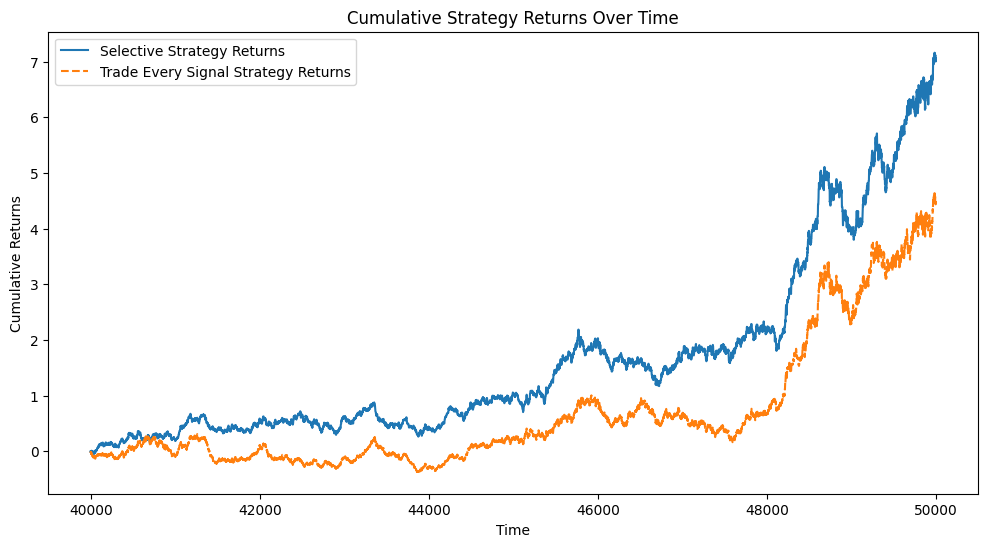

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_with_returns['cumulative_strategy_returns'], label='Selective Strategy Returns')
plt.plot(test_data_with_baseline_returns['cumulative_baseline_strategy_returns'], label='Trade Every Signal Strategy Returns', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Strategy Returns Over Time')
plt.legend()
plt.show()